<a href="https://colab.research.google.com/github/Jesuisgmo/transcriptomics_homework/blob/main/homework_2_with_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk
To: /content/EM_dataset.csv
100% 12.6k/12.6k [00:00<00:00, 10.2MB/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


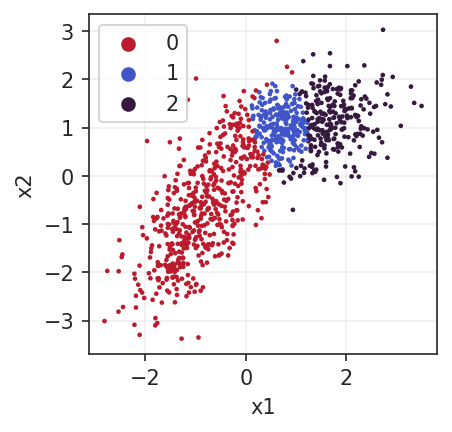

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import logsumexp

df = pd.read_csv("EM_dataset.csv")

# Зададим параметры ϕ,μ1,σ1,μ2,σ2 случайно

def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())

params = {
    "phi1" : np.random.uniform(0, 0.5), # Доля точек, принадлежащих к кластеру 1
    "phi2" : np.random.uniform(0, 0.5), # Доля точек, принадлежащих к кластеру 2

    "mu1" : np.random.normal(0, 1, size=2), # Центр распределения 1
    "mu2" : np.random.normal(0, 1, size=2), # Центр распределения 2
    "mu3" : np.random.normal(0, 1, size=2), # Центр распределения 3

    "sigma1": get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma2" : get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma3" : get_random_psd() # У 2d Гауссианы таким образом задаётся дисперсия
}

# for param in params:
#   print(f"{param}:")
#   print(params[param], "\n")

# Распределим точки в соответствии со сгенерированными Гауссианами

X = df.values

def E_step(X, params, draw=False):
  LogLikelihood = A = np.log([
      stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X),
      stats.multivariate_normal(params["mu2"], params["sigma2"]).pdf(X),
      stats.multivariate_normal(params["mu3"], params["sigma3"]).pdf(X)
  ])
  logPrior = B = np.log([1 - params["phi1"]+params["phi2"], params["phi2"], params["phi1"]])
  logPosterior = D = logPrior + LogLikelihood.T
  RealSoftMax = C = logsumexp(logPosterior, axis=1)
  probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)

  return RealSoftMax, probabilities

# Запустим и отрисуем

total_prob, probabilities = E_step(X, params)
# print("total_prob: ", total_prob, "probabilities: ", probabilities)

# Оптимизируем параметр  θ  по тому, как мы определили принадлежность точек к кластерам на позапрошлом шаге

def M_step(X, params, probabilities):
  prob_1 = probabilities[:, 0]
  prob_2 = probabilities[:, 1]
  prob_3 = probabilities[:, 2]

  # Вычисление новых значений
  # Пропорция = prior
  phi1 = prob_1.sum() / len(X)
  phi2 = prob_2.sum() / len(X)

  # Среднее
  mu1 = prob_1.dot(X) / np.sum(prob_1)
  mu2 = prob_2.dot(X) / np.sum(prob_2)
  mu3 = prob_3.dot(X) / np.sum(prob_2)

  # Дисперсия
  sigma1 = (X - mu1).T.dot((X - mu1) * np.array([prob_1]).T) / np.sum(prob_1)
  sigma2 = (X - mu2).T.dot((X - mu2) * np.array([prob_2]).T) / np.sum(prob_2)
  sigma3 = (X - mu3).T.dot((X - mu3) * np.array([prob_3]).T) / np.sum(prob_3)

  return {
      "phi1" : phi1, "phi2" : phi2,
      "mu1" : mu1, "mu2" : mu2, "mu3" : mu3,
      "sigma1": sigma1, "sigma2": sigma2, "sigma3": sigma3
  }

# Сделаем так, чтобы это выполнялось до тех пор, пока LogLikelihood не перестанет уменьшаться меньше, чем на 0.00000001.

def run_EM(X, params, draw=False):
    import imageio
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params, draw=draw)
        avg_allprob.append(np.mean(allprob))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.000000001:
            break
        params = M_step(X, params, probabilities)

    loglikelihood, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

# Запустим и отрисуем

pred, prob, allprob = run_EM(X, params, draw=True)
# print("pred: ", pred, "prob: ", prob, "allprob: ", allprob)

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: sns.color_palette("coolwarm", n_colors=50)[-1],
                         1: sns.color_palette("coolwarm", n_colors=50)[0],
                         2: sns.color_palette("rocket")[0]})
ax.grid(alpha=0.3)
plt.show()

In [1]:
!git clone https://github.com/pachterlab/kallisto.git
!apt-get install autoconf
!cd kallisto && mkdir build && cd build && cmake .. && make

Cloning into 'kallisto'...
remote: Enumerating objects: 4136, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 4136 (delta 79), reused 117 (delta 67), pack-reused 3986
Receiving objects: 100% (4136/4136), 4.24 MiB | 18.56 MiB/s, done.
Resolving deltas: 100% (2694/2694), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  automake autotools-dev libsigsegv2 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc libtool gettext m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev libsigsegv2 m4
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 1,082 kB of archives.
After this operation, 3,994 kB of additional disk

In [5]:
!./kallisto/build/src/kallisto index -i transcriptome.idx GCF_000001405.40_GRCh38.p14_rna.fna.gz


[build] loading fasta file GCF_000001405.40_GRCh38.p14_rna.fna.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 5158 target sequences
[build] warning: replaced 15 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... tcmalloc: large alloc 1610612736 bytes == 0x555a94d14000 @  0x7f69eb90c887 0x555a01c5982d 0x555a01c6140b 0x555a01c23f40 0x7f69ea78cc87 0x555a01c2c10a
tcmalloc: large alloc 3221225472 bytes == 0x555af4d14000 @  0x7f69eb90c887 0x555a01c5982d 0x555a01c6140b 0x555a01c23f40 0x7f69ea78cc87 0x555a01c2c10a
tcmalloc: large alloc 6442450944 bytes == 0x555bb55f4000 @  0x7f69eb90c887 0x555a01c5982d 0x555a01c6140b 0x555a01c23f40 0x7f69ea78cc87 0x555a01c2c10a
done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 991009 contigs and contains 142754887 k-mers 



In [13]:
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-ubuntu64.tar.gz
!tar -xvzf sratoolkit.3.0.0-ubuntu64.tar.gz
!sratoolkit.3.0.0-ubuntu64/bin/vdb-config -i

--2022-10-02 19:11:27--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-ubuntu64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.11, 2607:f220:41f:250::230, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85777118 (82M) [application/x-gzip]
Saving to: ‘sratoolkit.3.0.0-ubuntu64.tar.gz’

sratoolkit.3.0.0-ub 100%[===================>]  81.80M  85.9MB/s    in 1.0s    

2022-10-02 19:11:29 (85.9 MB/s) - ‘sratoolkit.3.0.0-ubuntu64.tar.gz’ saved [85777118/85777118]

sratoolkit.3.0.0-ubuntu64/
sratoolkit.3.0.0-ubuntu64/bin/
sratoolkit.3.0.0-ubuntu64/bin/abi-dump
sratoolkit.3.0.0-ubuntu64/bin/abi-dump.3
sratoolkit.3.0.0-ubuntu64/bin/abi-load
sratoolkit.3.0.0-ubuntu64/bin/abi-load.3
sratoolkit.3.0.0-ubuntu64/bin/align-info
sratoolkit.3.0.0-ubuntu64/bin/align-info.3
sratoolkit.3.0.0-ubuntu64/bin/bam-load
sratoolki

In [14]:
!wget https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
!unzip fastqc_v0.11.9.zip

!chmod +x FastQC/fastqc
!mkdir qc

!pip3 install multiqc

--2022-10-02 19:12:26--  https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
Resolving www.bioinformatics.babraham.ac.uk (www.bioinformatics.babraham.ac.uk)... 149.155.133.4
Connecting to www.bioinformatics.babraham.ac.uk (www.bioinformatics.babraham.ac.uk)|149.155.133.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10249221 (9.8M) [application/zip]
Saving to: ‘fastqc_v0.11.9.zip’

fastqc_v0.11.9.zip  100%[===================>]   9.77M  3.79MB/s    in 2.6s    

2022-10-02 19:12:30 (3.79 MB/s) - ‘fastqc_v0.11.9.zip’ saved [10249221/10249221]

Archive:  fastqc_v0.11.9.zip
  inflating: FastQC/cisd-jhdf5.jar   
   creating: FastQC/Configuration/
  inflating: FastQC/Configuration/adapter_list.txt  
  inflating: FastQC/Configuration/contaminant_list.txt  
  inflating: FastQC/Configuration/limits.txt  
  inflating: FastQC/fastqc           
  inflating: FastQC/fastqc_icon.ico  
   creating: FastQC/Help/
   creating: FastQC/Help/1 Introductio

In [15]:
!curl -fsSL https://get.nextflow.io | bash
!./nextflow run --SRA SRR6410603 --INDEX transcriptome.idx hw2_pipeline.nf


      N E X T F L O W
      version 22.04.5 build 5708
      created 15-07-2022 16:09 UTC 
      cite doi:10.1038/nbt.3820
      http://nextflow.io


Nextflow installation completed. Please note:
- the executable file `nextflow` has been created in the folder: /content
- you may complete the installation by moving it to a directory in your $PATH

N E X T F L O W  ~  version 22.04.5
Launching `hw2_pipeline.nf` [agitated_edison] DSL2 - revision: 50f9110cfe

  E X P R E S S I O N S  
SRA number         : [SRR6410603]
Results location   : results/
[-        ] process > DownloadFastQ -
[-        ] process > QC            -
[-        ] process > MultiQC       -

[-        ] process > DownloadFastQ -
[-        ] process > QC            -
[-        ] process > MultiQC       -
[-        ] process > Kallisto      -

[-        ] process > DownloadFastQ [  0%] 0 of 1
[-        ] process > QC            -
[-        ] process > MultiQC       -
[-        ] process > Kallisto      -

executor >  loca

In [24]:
!./nextflow run --SRA SRR6410603 --INDEX /content/transcriptome.idx hw2_pipeline.nf -resume

N E X T F L O W  ~  version 22.04.5
Launching `hw2_pipeline.nf` [extravagant_swartz] DSL2 - revision: d399d6bfd0

  E X P R E S S I O N S  
SRA number         : [SRR6410603]
Results location   : results/
[-        ] process > DownloadFastQ -
[-        ] process > QC            -

[-        ] process > DownloadFastQ -
[-        ] process > QC            -
[-        ] process > MultiQC       -
[-        ] process > Kallisto      -

[e5/dd367e] process > DownloadFastQ (1) [100%] 1 of 1, cached: 1
[-        ] process > QC                -
[-        ] process > MultiQC           -
[-        ] process > Kallisto          -

[e5/dd367e] process > DownloadFastQ (1) [100%] 1 of 1, cached: 1 ✔
[c1/6858be] process > QC (1)            [100%] 1 of 1, cached: 1 ✔
[43/c2f5df] process > MultiQC           [100%] 1 of 1, cached: 1 ✔
[-        ] process > Kallisto          [  0%] 0 of 1

executor >  local (1)
[e5/dd367e] process > DownloadFastQ (1) [100%] 1 of 1, cached: 1 ✔
[c1/6858be] process > QC (1) 

In [18]:
!cp transcriptome.idx ./kallisto/build/src/